In [23]:
import numpy as np
from timeit import timeit as timeit
import os
import matplotlib.pyplot as plt
import subprocess
from joblib import Parallel, delayed
import multiprocessing 
import pandas as pd

# **I - Formatage des données**

## Conversion du format SNP vers SMC
Ici on convertit une matrice SNP en SMC. Dans ces deux fonctions on va juste gérer les colonnes ( données )

**15,1 Go sans compression vs 2,31 Go avec compression**

In [24]:
def SNPtoSMC(dist, SNP, POS):
    """
    dist : id de l'individu distingué
    SNP : matrice de SNPs
    POS : postions de la matrice de SNPs
    return : une matrice au format SMC
    """
    N = SNP.shape[0]
    M = POS.shape[0]
    N = N if N%2 == 0 else N - 1
    SNP = SNP[:N]
    # on remplace les 0 de la matrice de position par des 1
    POS[POS == 0] = 1
    assert dist < N/2
    
    dist *= 2
    SMC = np.zeros((2*M,4), dtype=int)
    SMC[:,-1] = N*np.ones(2*M, dtype=int) - 2
    SMC[:, 0] = np.ones(2*M, dtype=int)
    d = SNP[dist, :] + SNP[dist+1, :]
    u = np.sum(SNP, axis=0, dtype=int) - d
    SMC[1::2, 1:-1] = np.transpose([d, u]) 
    SMC[0::2, 0:-1] = np.transpose([POS - 1, np.zeros(M, dtype=int), np.zeros(M, dtype=int)])
    todelete = np.argwhere(POS <= 1).transpose()*2
    return np.delete(SMC, todelete, 0)

In [25]:
def loadfile(scenario, i, path="hdgp/scenario_",form=".npz"):
    file_name = path + scenario +"/hdgp_" + scenario + "_" + str(i) + form
    print(file_name)
    data = np.load(file_name)
    return data

In [26]:
data = loadfile("1576", 1)
print(data["SNP"].shape)

hdgp/scenario_1576/hdgp_1576_1.npz
(74, 654)


Le les fichiers SMC ont besoin d'un header qui décrit la version du logiciel, une liste des individus distingués et une liste des individus non distingués.
On crée alors une fonction qui prend en paramèmtre l'identifiant de la population considérée, l'individu distingué et le nombre total d'individus.
La fonction renvoie le header correspondant.

In [27]:
def header_smc(pid, dist, n_ind):
    """
    pid: id de la population considérée
    dist: individu distingué
    n_ind: nombre d'individus
    return: le header correspondant pour le format SMC
    """
    header = 'SMC++ {"version": "1.15.4.dev18+gca077da", "pids": ["'+ pid +'"], "undist": [['
    for i in range(n_ind):
        if(i != dist):
            indid = pid + str(i)
            header += '["' + indid + '", 0], ["' + indid + '", 1], '
    indid = pid + str(dist)
    header = header[:-2] + ']], "dist": [[["' + indid +'", 0], ["' + indid + '", 1]]]}'
    return header

In [28]:
## test sur un exemple simple
def test():
    snp = np.array([
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    ])
    pos = np.array([3, 5, 1, 10])
    print(SNPtoSMC(0, snp, pos))
    print(SNPtoSMC(1, snp, pos))
    print(SNPtoSMC(2, snp, pos))
test()

[[2 0 0 4]
 [1 0 2 4]
 [4 0 0 4]
 [1 0 1 4]
 [1 1 0 4]
 [9 0 0 4]
 [1 2 1 4]]
[[2 0 0 4]
 [1 2 0 4]
 [4 0 0 4]
 [1 0 1 4]
 [1 0 1 4]
 [9 0 0 4]
 [1 0 3 4]]
[[2 0 0 4]
 [1 0 2 4]
 [4 0 0 4]
 [1 1 0 4]
 [1 0 1 4]
 [9 0 0 4]
 [1 1 2 4]]


In [29]:
## mesure du temps prise par la fonction SNPtoSMC
n = 1000
data = loadfile(scenario="6", i="5")
SMC = SNPtoSMC(0, data['SNP'], data['POS'])
print(SMC[:10])
time = timeit("SNPtoSMC(0, data['SNP'], data['POS'])", globals=globals(), number=n)/n
print(f"\nSNPtoSMC exec time {time:.5f}s")

print(f"Nombre de 0 dans la matrice de position : {np.sum(data['POS'] == 0)}")
assert (SMC[:, 0] > 0).any()

hdgp/scenario_6/hdgp_6_5.npz
[[ 320    0    0   34]
 [   1    1   17   34]
 [1091    0    0   34]
 [   1    0    3   34]
 [  54    0    0   34]
 [   1    1   17   34]
 [ 705    0    0   34]
 [   1    1    4   34]
 [ 210    0    0   34]
 [   1    0    2   34]]

SNPtoSMC exec time 0.00166s
Nombre de 0 dans la matrice de position : 19


La première fonction sert à générer tous les fichiers SMC pour toutes données.
Alors que la seconde fonction c'est juste pour un scénario en particulier

In [30]:
def one_scenario(d="scenario_11687", save_dir="smc_files"):
    if save_dir not in os.listdir():
        os.mkdir(save_dir)
    for file in os.listdir("hdgp/" + d):
        # chargement des données
        data = np.load("hdgp/" + d + "/" + file)
        SNP, POS = data['SNP'], data['POS']
        # remplace tous les 0 de la matrice de positions par des 1
        POS[POS == 0] = 1 
        # on récupère le nombre d'individus (on le suppose pair)
        N = data['SNP'].shape[0]
        N = N if N%2 == 0 else N - 1
        # création du dossier du scénario
        scenario_dir = save_dir + "/" + d
        if d not in os.listdir(save_dir):
            os.mkdir(scenario_dir)
            
        for dist in range(0, int(N/2)):
            # pour chaque individu distingué, on crée un dossier qui contient les fichiers smc associés
            dist_dir = scenario_dir + "/" + "dist_" + str(dist)
            if "dist_" + str(dist) not in os.listdir(scenario_dir):
                os.mkdir(dist_dir)
            SMC = SNPtoSMC(dist, SNP, POS)
            filename = dist_dir + "/" + file + str(dist) + ".smc"
            header = header_smc("hdgp", dist, N)
            np.savetxt(filename , SMC, delimiter=' ', fmt = "%d", header=header)
            
def one_scenario_compressed (d="scenario_11687", save_dir="smc.gz_files"):
    if save_dir not in os.listdir():
        os.mkdir(save_dir)
    for file in os.listdir("hdgp/" + d):
        # chargement des données
        data = np.load("hdgp/" + d + "/" + file)
        SNP, POS = data['SNP'], data['POS']
        # remplace tous les 0 de la matrice de positions par des 1
        POS[POS == 0] = 1 
        # on récupère le nombre d'individus (on le suppose pair)
        N = data['SNP'].shape[0]
        N = N if N%2 == 0 else N - 1
        # création du dossier du scénario
        scenario_dir = save_dir + "/" + d
        if d not in os.listdir(save_dir):
            os.mkdir(scenario_dir)
            
        for dist in range(0, int(N/2)):
            # pour chaque individu distingué, on crée un dossier qui contient les fichiers smc associés
            dist_dir = scenario_dir + "/" + "dist_" + str(dist)
            if "dist_" + str(dist) not in os.listdir(scenario_dir):
                os.mkdir(dist_dir)
            SMC = SNPtoSMC(dist, SNP, POS)
            filename = dist_dir + "/" + file + str(dist) + ".smc.gz"
            header = header_smc("hdgp", dist, N)
            np.savetxt(filename , SMC, delimiter=' ', fmt = "%d", header=header)
            
def all_scenarios(multi_thread=False, compressed=True):
    if(multi_thread):
        num_cores = multiprocessing.cpu_count()
        if not compressed:
            Parallel(n_jobs=num_cores)(delayed(one_scenario)(d) for d in os.listdir("hdgp"))
        else: 
            Parallel(n_jobs=num_cores)(delayed(one_scenario_compressed)(d) for d in os.listdir("hdgp"))
    else:
        for d in os.listdir("hdgp"):
            if not compressed:
                one_scenario(d)
            else:
                one_scenario_compressed(d)

In [31]:
#n = 3
#time = timeit('one_scenario("scenario_6")', globals=globals(), number=n)/n
#print(f"{time:.2f}s pour convertir tous les fichiers du scénario 6")
#n = 1
#time = timeit("all_scenarios(True)", globals=globals(), number=n)/n
#print(f"{time:.2f}s pour convertir tous les scénarios")

In [32]:
n = 3
#time = timeit('one_scenario("scenario_6")', globals=globals(), number=n)/n
#print(f"{tim:.2f}s pour convertir tous les fichiers du scénario 6")

**Le scenario 157 est assez lourd**

In [33]:
n = 3
#time = timeit('one_scenario("scenario_157")', globals=globals(), number=n)/n
#print(f"{time:.2f}s pour convertir tous les fichiers du scénario 157")

**Le scenario 565 est assez léger**

In [34]:
n = 3
#time = timeit('one_scenario("scenario_565")', globals=globals(), number=n)/n
#print(f"{time:.2f}s pour convertir tous les fichiers du scénario 565")

## Transformations de tous les scénarios au format smc compressé

In [35]:
n = 1
#time = timeit("all_scenarios(True)", globals=globals(), number=n)/n
#print(f"{time:.2f}s pour convertir tous les scénarios")

# **III- Prédictions**

In [36]:
def run_smc_estimate(scenario, out_dir="out", display=False):
    scenario_dir = f"smc.gz_files/{scenario}"
    scenario_out_dir = f"{out_dir}/{scenario}"
    if out_dir not in os.listdir():
        os.mkdir(out_dir)
    if scenario not in os.listdir(out_dir):
        os.mkdir(scenario_out_dir)
    for dist in os.listdir(scenario_dir):
        scenario_out_dist_dir = f"{scenario_out_dir}/{dist}"
        if dist not in os.listdir(scenario_out_dir):
            os.mkdir(scenario_out_dist_dir)
        command_estimate = f'smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o {scenario_out_dist_dir} {scenario_dir}/{dist}/*.gz'
        command_plot = f'smc++ plot {scenario_out_dist_dir}/plot.png {scenario_out_dist_dir}/model.final.json' 
        print(f"running : {command_estimate}")
        # estimate
        process = subprocess.Popen(command_estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        stdout, stderr = process.communicate()
        if(display):
            print(stdout, stderr)
        # plot the result
        process = subprocess.Popen(command_plot, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()

### Utilie pour faire les fichiers dont on a besoin

In [33]:
n = 1
time = timeit('run_smc_estimate("scenario_11687", display=False)', globals=globals(), number=n)/n
print(f"{time:.2f}s smc")

running : smc++ estimate 1.45e-08 --knots 22 --timepoints 0 34483 -o out/scenario_11687/dist_0 smc.gz_files/scenario_11687/dist_0/*.gz
running : smc++ estimate 1.45e-08 --knots 22 --timepoints 0 34483 -o out/scenario_11687/dist_1 smc.gz_files/scenario_11687/dist_1/*.gz
running : smc++ estimate 1.45e-08 --knots 22 --timepoints 0 34483 -o out/scenario_11687/dist_2 smc.gz_files/scenario_11687/dist_2/*.gz
running : smc++ estimate 1.45e-08 --knots 22 --timepoints 0 34483 -o out/scenario_11687/dist_3 smc.gz_files/scenario_11687/dist_3/*.gz
running : smc++ estimate 1.45e-08 --knots 22 --timepoints 0 34483 -o out/scenario_11687/dist_4 smc.gz_files/scenario_11687/dist_4/*.gz
running : smc++ estimate 1.45e-08 --knots 22 --timepoints 0 34483 -o out/scenario_11687/dist_5 smc.gz_files/scenario_11687/dist_5/*.gz
1973.42s smc


In [41]:
def run_smc_plot(scenario, out_dir="out", display=False):
    scenario_dir = f"smc_files/{scenario}"
    scenario_out_dir = f"{out_dir}/{scenario}"
    assert out_dir in os.listdir()
    assert scenario in os.listdir(out_dir)
    for dist in os.listdir(scenario_dir):
        scenario_out_dist_dir = f"{scenario_out_dir}/{dist}"
        assert dist in os.listdir(scenario_out_dir)
        command_plot = f'smc++ plot -c {scenario_out_dist_dir}/plot.png {scenario_out_dist_dir}/model.final.json' 
        print(f"running : {command_plot}")
        # plot the result
        process = subprocess.Popen(command_plot, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()

In [10]:
run_smc_plot("scenario_11687")

running : smc++ plot -c out/scenario_11687/dist_5/plot.png out/scenario_11687/dist_5/model.final.json
running : smc++ plot -c out/scenario_11687/dist_3/plot.png out/scenario_11687/dist_3/model.final.json
running : smc++ plot -c out/scenario_11687/dist_0/plot.png out/scenario_11687/dist_0/model.final.json
running : smc++ plot -c out/scenario_11687/dist_4/plot.png out/scenario_11687/dist_4/model.final.json
running : smc++ plot -c out/scenario_11687/dist_1/plot.png out/scenario_11687/dist_1/model.final.json
running : smc++ plot -c out/scenario_11687/dist_2/plot.png out/scenario_11687/dist_2/model.final.json


## Je fais la moyenne des courbes sur les mêmes intervalles de temps ici

In [16]:
def meanPlot(scenario):
    csv = pd.read_csv(f"out/scenario_{scenario}/dist_{0}/plot.csv") 
    y = csv['y'].to_numpy()

    fig, ax = plt.subplots(1, 1)
    ax.plot(csv['x'].to_numpy(), y, label=f"scénario_{scenario}.dist{0}")
    
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.set_xlim(100,10e3+1000)
    ax.legend()


**On observe la même courbe faite à partir du csv que celle qui est générée, enfin plus ou moins**

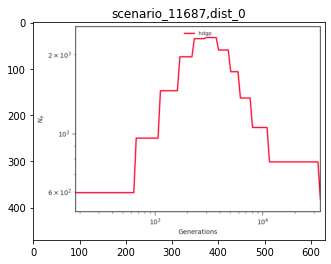

In [27]:
fig = plt.imread(f"out/scenario_{scenario}/dist_{0}/plot.png")
plt.title(f"scenario_{11687},dist_{0}")
plt.imshow(fig)
plt.show()

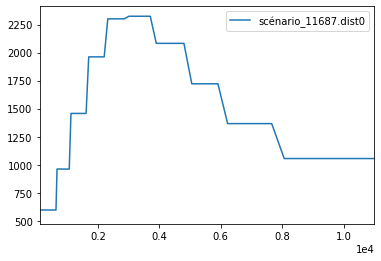

In [29]:
meanPlot(11687) 

In [81]:
def plotDist(scenario, populationStyle=True):
    fig, ax = plt.subplots(1, 1, figsize=(13,6))
    n_ind = len(os.listdir(f'out/scenario_{scenario}'))
    for dist in range(n_ind):
        file = f'out/scenario_{scenario}/dist_{dist}/plot.csv'
        csv = pd.read_csv(file)
        if populationStyle:
            X, Y = toPlotPopulation(csv['x'].to_numpy(), csv['y'].to_numpy())
        else:
            X, Y = csv['x'].to_numpy(), csv['y'].to_numpy()
        ax.plot(X, Y, label=f'dist_{dist}')
    
    ax.set_xlim(0,10e3+1000)
    ax.set_yscale('log')
    ax.legend()
    ax.plot()

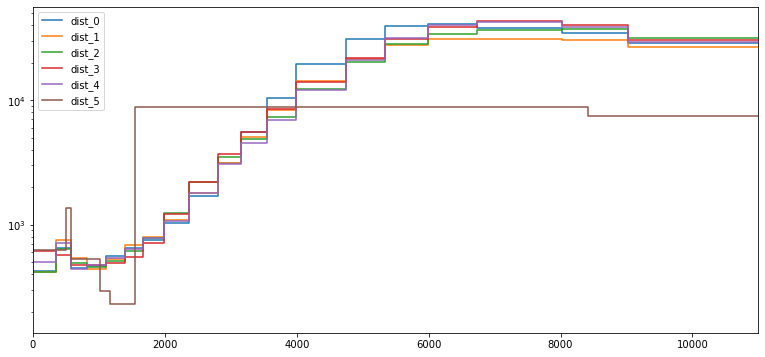

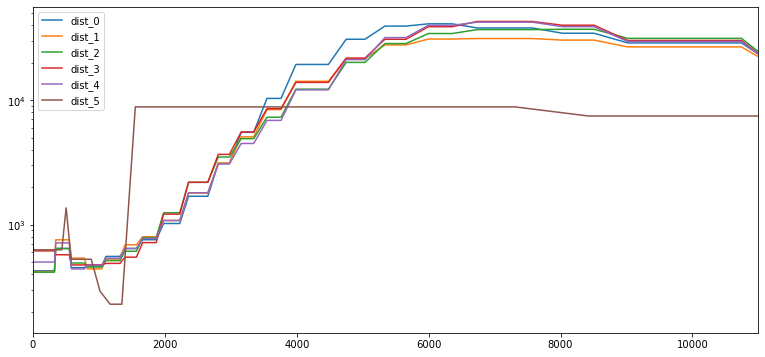

In [82]:
plotDist(11687)
plotDist(11687, False)

In [74]:
def meanPlot(scenario):
    csv = pd.read_csv(f"out/scenario_{scenario}/dist_{0}/plot.csv") 
    x = csv['x'].to_numpy().tolist()
    # je construit le grand intervalle ici
    for dist in range(0,6):
        csv = pd.read_csv(f"out/scenario_{scenario}/dist_{dist}/plot.csv") 
        x_temp = csv['x'].to_numpy().tolist()
        for i in x_temp:
            if i not in x:
                x.append(i)
    x = np.array(x)
    x = np.sort(x)
    y = np.zeros(len(x))
    for dist in range(1,6):
        csv = pd.read_csv(f"out/scenario_{scenario}/dist_{dist}/plot.csv")
        y_res = complete(x,csv['x'].to_numpy(),csv['y'].to_numpy())
        y += y_res
    y = y/5
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, y, label=f"scénario_{scenario} moyenne")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.set_xlim(0,10e3+1000)
    ax.legend()
    return x,y

# ici il faut faire attention aux résultats de cette fonction
def complete(x,x_v,y_v):
    y_res = np.zeros(len(x))
    compteur_x = 0
    compteur_y=0
    for val in x_v:
        if x[compteur_x] == val:
            y_res[compteur_x] = y_v[compteur_y]
            compteur_x +=1
        while  x[compteur_x] <= val:
            y_res[compteur_x] = y_v[compteur_y]
            compteur_x +=1
            if compteur_x  == len(x):
                break
        compteur_y +=1
    return y_res

In [179]:
complete( [1,2,3,4,5],[1,3,5],[10,11,215])

array([ 10.,  11.,  11., 215., 215.])

In [14]:
#meanPlot(11687)

# **Partie Adygei**

Dans cette partie, on va comparer le temps d'exécution et les résultats sur l'estimation smc, entre les fichiers de SNP et le fichier VCF.
Les fichiers SNPs et les VCFs représentent les mêmes données, sous deux formats différents.

On se concentre sur le chromosome21, avec 16 individus comme sample.

Voici les fichiers SNPs associées
```
npz_data_pop_ancestral_derived $ ls -l | grep chr21
-rw-r--r-- 1 jerome jerome  5665 Dec  1  2020 Adygei_chr21_1.npz
-rw-r--r-- 1 jerome jerome  6266 Dec  1  2020 Adygei_chr21_10.npz
-rw-r--r-- 1 jerome jerome  6071 Dec  1  2020 Adygei_chr21_11.npz
-rw-r--r-- 1 jerome jerome  3672 Dec  1  2020 Adygei_chr21_12.npz
-rw-r--r-- 1 jerome jerome  5833 Dec  1  2020 Adygei_chr21_13.npz
-rw-r--r-- 1 jerome jerome  4055 Dec  1  2020 Adygei_chr21_14.npz
-rw-r--r-- 1 jerome jerome  5206 Dec  1  2020 Adygei_chr21_15.npz
-rw-r--r-- 1 jerome jerome  7222 Dec  1  2020 Adygei_chr21_16.npz
-rw-r--r-- 1 jerome jerome  5802 Dec  1  2020 Adygei_chr21_2.npz
-rw-r--r-- 1 jerome jerome  6950 Dec  1  2020 Adygei_chr21_3.npz
-rw-r--r-- 1 jerome jerome  6251 Dec  1  2020 Adygei_chr21_4.npz
-rw-r--r-- 1 jerome jerome  6116 Dec  1  2020 Adygei_chr21_5.npz
-rw-r--r-- 1 jerome jerome  5602 Dec  1  2020 Adygei_chr21_6.npz
-rw-r--r-- 1 jerome jerome  5624 Dec  1  2020 Adygei_chr21_7.npz
-rw-r--r-- 1 jerome jerome  6579 Dec  1  2020 Adygei_chr21_8.npz
-rw-r--r-- 1 jerome jerome  6916 Dec  1  2020 Adygei_chr21_9.npz

```

Voici les 16 individus du fichier VCF
```
HGDP01396	HGDP01382	HGDP01403	HGDP01404	HGDP01402	HGDP01383	HGDP01401	HGDP01400	HGDP01384	HGDP01398	HGDP01397	HGDP01388	HGDP01387	HGDP01386	HGDP01385	HGDP01399
```

**On commence par transformer le fichier vcf dans le format accepté par SMC :
Pour cela, il faut indexer le vcf et le fichier mask avec tabix**

In [89]:
adygei_folder = "Adygei"
vcf_file = "Adygei_hgdp_wgs.20190516.full.chr21.vcf"
mask_file = "hgdp_wgs.20190516.mask.bed"
for file in [vcf_file, mask_file]:
    bgzip = f"bgzip {adygei_folder}/{file}"
    tabix = f"tabix {adygei_folder}/{file}.gz"
    process = subprocess.Popen(bgzip, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    stdout, stderr = process.communicate()
    print(stdout, stderr)
    process = subprocess.Popen(tabix, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    stdout, stderr = process.communicate()
    print(stdout, stderr)
vcf2smc = f"smc++ vcf2smc {adygei_folder}/{vcf_file}.gz {adygei_folder}/out.smc -m {adygei_folder}/hgdp_wgs.20190516.mask.bed.gz chr21 HGPD:HGDP01396,HGDP01382,HGDP01403,HGDP01404,HGDP01402,HGDP01383,HGDP01401,HGDP01400,HGDP01384,HGDP01398,HGDP01397,HGDP01388,HGDP01387,HGDP01386,HGDP01385,HGDP01399"
process = subprocess.Popen(vcf2smc, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print(f"executing: {vcf2smc}")
stdout, stderr = process.communicate()
#print(stdout, stderr)

 [bgzip] can't create Adygei/Adygei_hgdp_wgs.20190516.full.chr21.vcf.gz: File exists

 [tabix] the index file exists. Please use '-f' to overwrite.

 [bgzip] can't create Adygei/hgdp_wgs.20190516.mask.bed.gz: File exists

 [tabix] the index file exists. Please use '-f' to overwrite.

executing: smc++ vcf2smc Adygei/Adygei_hgdp_wgs.20190516.full.chr21.vcf.gz Adygei/out.smc -m Adygei/hgdp_wgs.20190516.mask.bed.gz chr21 HGPD:HGDP01396,HGDP01382,HGDP01403,HGDP01404,HGDP01402,HGDP01383,HGDP01401,HGDP01400,HGDP01384,HGDP01398,HGDP01397,HGDP01388,HGDP01387,HGDP01386,HGDP01385,HGDP01399


**Puis on fait une estimation:**

In [120]:
estimate = f"smc++ estimate 1e-8 {adygei_folder}/out.smc -o {adygei_folder} --timepoints 0 10000"
process = subprocess.Popen(estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
timecsv = timeit('process.communicate()', globals=globals(), number=1)

**On fait la même chose mais avec notre fonction adygei_folder**

In [121]:
if "snptosmc" not in os.listdir(adygei_folder):
    os.mkdir(f"{adygei_folder}/snptosmc")
for i in range(1, 17):
    data = np.load(f"{adygei_folder}/snps/Adygei_chr21_{i}.npz")
    SNP = data["SNP"]
    POS = data["POS"]
    SMC = SNPtoSMC(1, SNP, POS)
    header = header_smc("adygei", 1, SNP.shape[0])
    np.savetxt(f"{adygei_folder}/snptosmc/chr21_{i}.smc" , SMC, delimiter=' ', fmt = "%d", header=header)

**On fait l'estimation**

In [122]:
estimate = f"smc++ estimate 1e-8 {adygei_folder}/snptosmc/*.smc -o {adygei_folder}/snptosmc --timepoints 0 10000"
process = subprocess.Popen(estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
timesnp = timeit('process.communicate()', globals=globals())

**On affiche ces deux estimations**

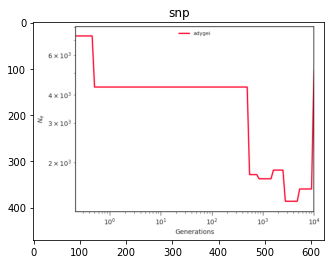

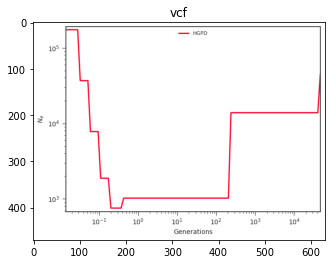

temps pour snp :26.6min,
pour csv 10.8min


AssertionError: 

In [123]:
plot = f"smc++ plot -c {adygei_folder}/plot.png {adygei_folder}/model.final.json"
process = subprocess.Popen(plot, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)
plot = f"smc++ plot -c {adygei_folder}/snptosmc/plot.png {adygei_folder}/snptosmc/model.final.json"
process = subprocess.Popen(plot, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)
figsnp = plt.imread(f"{adygei_folder}/snptosmc/plot.png")
figvcf = plt.imread(f"{adygei_folder}/plot.png")
plt.title(f"snp")
plt.imshow(figsnp)
plt.show()
plt.title(f"vcf")
plt.imshow(figvcf)
plt.show()

print(f"temps pour snp :{timesnp/60:.1f}min,\npour csv {timecsv/60:.1f}min")

X_smc, Y_smc = loadCSV_plot(f"{adygei_folder}/snptosmc/plot.csv")
X_csv, Y_csv = loadCSV_plot(f"{adygei_folder}/plot.csv")
assert X_smc[0] == X_csv[0]
assert X_smc[-1] == X_csv[-1]
plotError(X_csv, Y_csv, X_smc, Y_smc)

On ne comprend pas pourquoi sur l'estimation à partir du csv, on n'a pas le bon intervalle.
Comme les résultats sont différents, on ne peut pas conclure sur le temps de calcul.

In [124]:
print(X_smc[-1], X_csv[-1])

10000.0 47129.51010176622


# **MSE**

* On s'interesse à calculer la MSE entre deux courbres sur les mêmes intervalles, mais avec des découpages différents.
* On prend donc un découpage de référence (ici le premier donné à la fonction MSE)
* On fait alors la moyenne pondéré de la taille de l'intervalle pour calculer l'erreur entre les deux courbes.

In [129]:
def toPlotPopulation(X, Y):
    """
    Cette fonction permet la création de 
    tableaux numpy pour faire un affichage
    de populations sur des intervalles
    """
    X2 = np.zeros(2*X.size)
    Y2 = np.zeros(2*Y.size)
    X2[1::2], X2[::2] = X, X
    Y2[1::2], Y2[::2] = Y, Y
    X2 = X2[1:]
    Y2 = Y2[:-1]
    N = X.size
    interval_size = max(X2) - min(X2)
    X2 = np.append(X2, X2[-1] + interval_size/N)
    Y2 = np.append(Y2, Y2[-1])
    return X2, Y2

In [130]:
def plotError(trueX, trueY, smcX, smcY):
    mse, error = MSE(trueX, trueY, smcX, smcY)
    trueX2, trueY2 = toPlotPopulation(trueX, trueY)
    smcX2, smcY2 = toPlotPopulation(smcX, smcY)
    trueX2, error2 = toPlotPopulation(trueX, error)
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.plot(trueX2, trueY2, label='true')
    ax.plot(smcX2, smcY2, label='smc')
    ax.plot(trueX2, error2, c='red', label='error')
    ax.set_title(f"MSE={mse:.2f}")
    ax.set_yscale('log')
    ax.legend()

In [131]:
def MSE(trueX, trueY, smcX, smcY):
    """
    Prend deux estimations sur des intervalles de même taille, mais avec des découpages différents.
    Renvoie l'erreur et la MSE par rapport au découpage des données "true"
    """
    assert trueX[0] == smcX[0]
    assert trueX[-1] == smcX[-1]
    error = np.zeros(len(trueX))
    for i in range(1, len(trueX)):
        validIds = (smcX >= trueX[i-1]) * (smcX <= trueX[i])
        subX = smcX[validIds]
        subY = smcY[validIds]
        if trueX[i-1] not in subX:
            subX = np.insert(subX, 0, trueX[i-1])
            lastId = np.argwhere(smcX < trueX[i-1])[-1]
            subY = np.insert(subY, 0, smcY[lastId])
        if trueX[i] not in subX:
            subX = np.append(subX, trueX[i])
            subY = np.append(subY, subY[-1])
        subX /= (max(subX) - min(subX))
        subX = subX[1:] - subX[:-1]
        error[i-1] = abs(np.dot(subX, subY[:-1]) - trueY[i-1])
    error[-1] = abs(np.dot(subX[-1], subX[-1]) - trueY[-1])
    mse = np.sum(np.dot(error, error))/len(error)
    return mse, error

**On teste les fonctions plotError et MSE avec des fonctions simples**

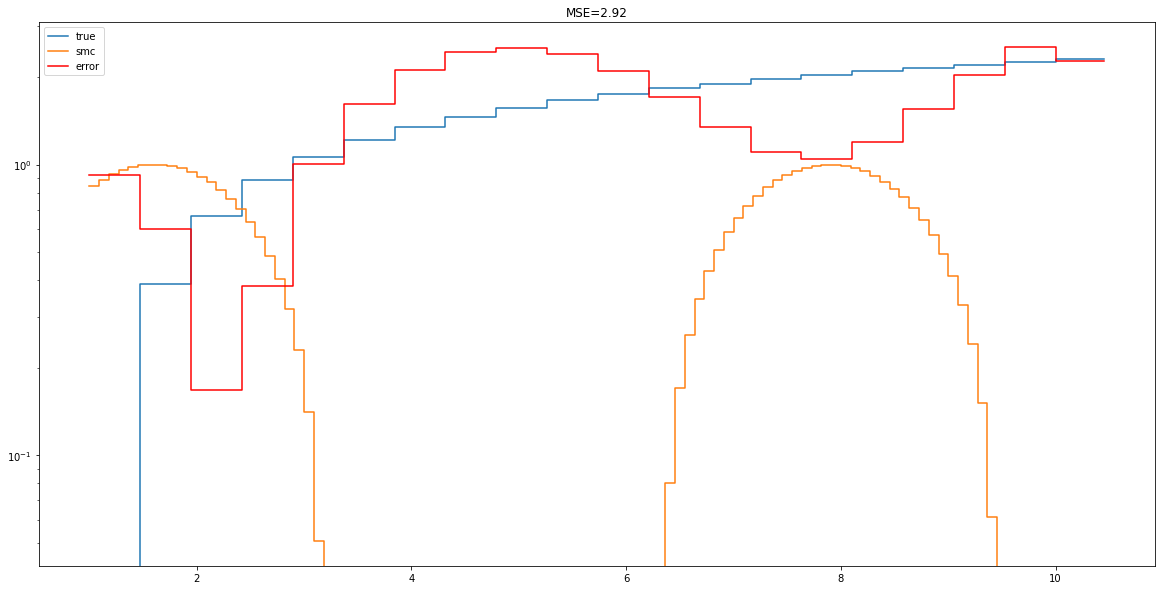

In [517]:
trueX = np.linspace(1, 10, 20)
smcX = np.linspace(1, 10, 100)
trueY = np.log(trueX)
smcY = np.sin(smcX)
plotError(trueX, trueY, smcX, smcY)

# Partie comparaison VCF et SMC

L'objectif est de comparer notre parser SNP → SMC avec le programme vcf2smc de smc++.
On commence par charger les données en mémoire.

In [103]:
def loadCSV_plot(file):
    smcData = pd.read_csv(file, sep=',')
    X = smcData['x'].to_numpy()
    Y = smcData['y'].to_numpy()
    return X, Y
    
def loadCSV_subsample(scenario = 11687):
    trueData = np.genfromtxt('hdgp_demo_parameters_subsample.csv',delimiter=',', dtype=int)
    trueX = trueData[1,6:27]
    ids = np.argwhere(trueData[:,0] == scenario)
    trueY = trueData[ids,27:].flatten()
    
    dist = 0
    file = f'out/scenario_{scenario}/dist_{dist}/plot.csv'
    smcData = pd.read_csv(file)
    smcX = smcData['x'].to_numpy()
    smcY = smcData['y'].to_numpy()
    return trueX, trueY, smcX, smcY

def generate_string_vcftosmc(pop, N):
    """
    pop: the name of the poppulation
    N: the number of individuals (not the number of chromosomes)
    """
    string = f"{pop}:"
    for i in range(N):
        string += f"{pop}_{i},"
    return string[:-1]

In [107]:
directory = "data_hdgp_2mb_vcf"
hdgp_dir = f"{directory}/hdgp"
scenario = "46"
indiv = "73"
scenario_dir = f"{hdgp_dir}/scenario_{scenario}"
dist = 0
file = f"{scenario_dir}/hdgp_{scenario}_{indiv}"
smc_dir = f"{directory}/smc"
if "smc" not in os.listdir(directory):
    os.mkdir(smc_dir)
if f"scenario_{scenario}" not in os.listdir(smc_dir):
    os.mkdir(f"{smc_dir}/scenario_{scenario}")
smc_file_vcf = f"{smc_dir}/scenario_{scenario}/hdgp_{scenario}_{indiv}.vcf.smc"
smc_file_snp = f"{smc_dir}/scenario_{scenario}/hdgp_{scenario}_{indiv}.snp.smc"

## convertir le snp en smc
data = np.load(f"{file}.npz")
SNP, POS = data["SNP"], data["POS"]
N = len(SNP) if len(SNP) % 2 == 0 else len(SNP) - 1
print(f"N={N}, scenario {scenario}")
SMC_snp = SNPtoSMC(dist, SNP, POS)
header = header_smc("tsk", dist, N)
np.savetxt(smc_file_snp, SMC_snp, delimiter=' ', fmt = "%d", header=header)

## convertir le vcf en smc
bgzip = f"bgzip {file}.vcf"
tabix = f"tabix {file}.vcf.gz"
process = subprocess.Popen(bgzip, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(bgzip, stdout, stderr)
process = subprocess.Popen(tabix, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(tabix, stdout, stderr)
string = generate_string_vcftosmc("tsk", int(N/2))
vcf2smc = f"smc++ vcf2smc {file}.vcf.gz {smc_file_vcf} 1 {string}"
process = subprocess.Popen(vcf2smc, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)

## récupérer les smc en mémoire
SMC_vcf = np.loadtxt(f"{smc_file_vcf}", dtype=int)
print(SMC_snp.shape, SMC_vcf.shape)
n = 0
minSize = min([SMC_snp.shape[0], SMC_vcf.shape[0]])
print(SMC_vcf[n:n+20], '\n')
print(SMC_snp[n:n+20], '\n')
print((SMC_vcf[:minSize] - SMC_snp[:minSize])[n:n+20])
print( f"{100*(SMC_vcf[:minSize] != SMC_snp[:minSize]).sum() / SMC_vcf.size:.2f}" , "% de différence")

N=10, scenario 46
bgzip data_hdgp_2mb_vcf/hdgp/scenario_46/hdgp_46_73.vcf  [bgzip] No such file or directory: data_hdgp_2mb_vcf/hdgp/scenario_46/hdgp_46_73.vcf

tabix data_hdgp_2mb_vcf/hdgp/scenario_46/hdgp_46_73.vcf.gz  [tabix] the index file exists. Please use '-f' to overwrite.

 925 smcpp.commands.vcf2smc WARNING Neither missing cutoff (-c) or mask (-m) has been specified. This means that stretches of the chromosome that do not have any VCF entries (for example, centromeres) will be interpreted as homozygous recessive.
925 smcpp.commands.vcf2smc INFO Population 1:
925 smcpp.commands.vcf2smc INFO Distinguished lineages: tsk_0:0, tsk_0:1
925 smcpp.commands.vcf2smc INFO Undistinguished lineages: tsk_1:0, tsk_1:1, tsk_2:0, tsk_2:1, tsk_3:0, tsk_3:1, tsk_4:0, tsk_4:1

  0%|          | 0.00/2.00M [00:00<?, ?bases/s]
100%|█████████▉| 2.00M/2.00M [00:00<00:00, 81.5Mbases/s]
952 smcpp.util   INFO Wrote 1491 observations

(1489, 4) (1491, 4)
[[10077     0     0     8]
 [    1     0     1    

**On observe 26% de différence. Cela est du aux décallages qu'il y a entre les deux fichiers.
En effet, on s'apercoit que les positions (transformées en positions relatives) du fichier VCF et les positions relatives du fichier SNP ne sont pas tout à fait identiques.**

**De plus, il y a des zéros dans les fichiers.
Sur ce scénario, il n'y a pas de 0 sur le VCF mais c'est n'est pas le cas de tous les scénarios.
Pour les SNP, nous remplaçons tous les 0 par des 1 dans notre fonction SNPtoSMC.**

In [105]:
command = f'gunzip {file}.vcf.gz; awk ' + "'{print $2}'" + f" {file}.vcf | tr '\n' ',' | sed -E 's/.*POS,//' | sed -E 's/.$//' "
process = subprocess.Popen(command, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
tab = np.fromstring(stdout, sep=',', dtype=int)
tab_relative = np.zeros(len(tab), dtype=int)
tab_relative[0] = tab[0]
for i in range(1, len(tab)):
    tab_relative[i] = tab[i] - tab[i-1]
n = 10
print("vcf positions", tab_relative[:n])
print("snp positions", POS[:n])
print("Les 0 dans les positions vcf", np.argwhere(tab_relative == 0 ).transpose())
print("Les 0 dans les positions snp", np.argwhere(POS == 0 ).transpose())
u, c = np.unique(tab, return_counts=True)
dup = u[c > 1]

vcf positions [10078  2528  2101   196  7787   347   576   714   483  2113]
snp positions [10078  2527  2100   196  7787   346   575   714   482  2112]
Les 0 dans les positions vcf []
Les 0 dans les positions snp []


### Prédictions sur ces fichiers

**Malgré les grosses différences entre les fichiers générés, on va quand même faire une estimation, puis comparer les résultats.**

In [450]:
# pour le fichier snp
estimate = f'smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 {smc_file_snp}'
process = subprocess.Popen(estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
model_snp = f"{smc_dir}/scenario_{scenario}/model_{scenario}_{indiv}.snp.json"
os.rename('model.final.json', model_snp)

# pour le ficher vcf
estimate = f'smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 {smc_file_vcf}'
process = subprocess.Popen(estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
model_vcf = f"{smc_dir}/scenario_{scenario}/model_{scenario}_{indiv}.vcf.json"
os.rename('model.final.json', model_vcf)

In [ ]:
model_snp = f"{smc_dir}/scenario_{scenario}/model_{scenario}_{indiv}.snp.json"
model_vcf = f"{smc_dir}/scenario_{scenario}/model_{scenario}_{indiv}.vcf.json"
# finalement on enregistre les résultats dans les fichiers csv
plot_snp = f"{smc_dir}/scenario_{scenario}/plot_{scenario}_{indiv}.snp.png"
csv_snp = f"{smc_dir}/scenario_{scenario}/plot_{scenario}_{indiv}.snp.csv"
plot = f"smc++ plot -c {plot_snp} {model_snp}"
process = subprocess.Popen(plot, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)

plot_vcf = f"{smc_dir}/scenario_{scenario}/plot_{scenario}_{indiv}.vcf.png"
csv_vcf = f"{smc_dir}/scenario_{scenario}/plot_{scenario}_{indiv}.vcf.csv"
plot = f"smc++ plot -c {plot_vcf} {model_vcf}"
process = subprocess.Popen(plot, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)

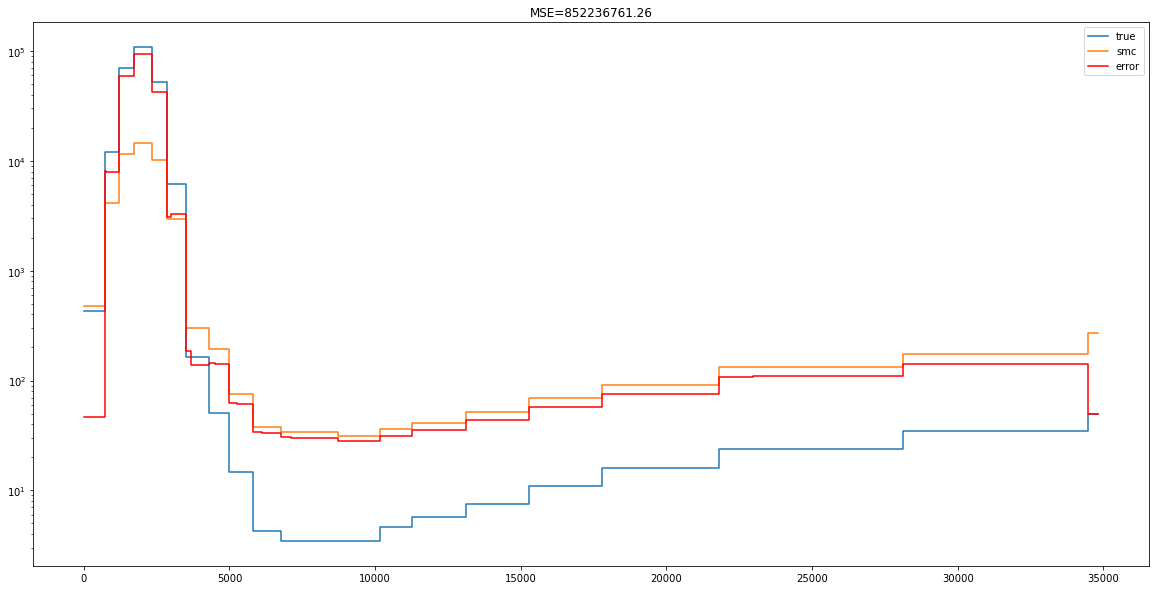

In [519]:
# affichage de l'erreur
Xsnp, Ysnp = loadCSV_plot(csv_snp)
Xvcf, Yvcf = loadCSV_plot(csv_vcf)
mse, error = MSE(Xvcf, Yvcf, Xsnp, Ysnp)
plotError(Xvcf, Yvcf, Xsnp, Ysnp)

**Ici, on compare autre le csv des données réelles avec nos estimations**

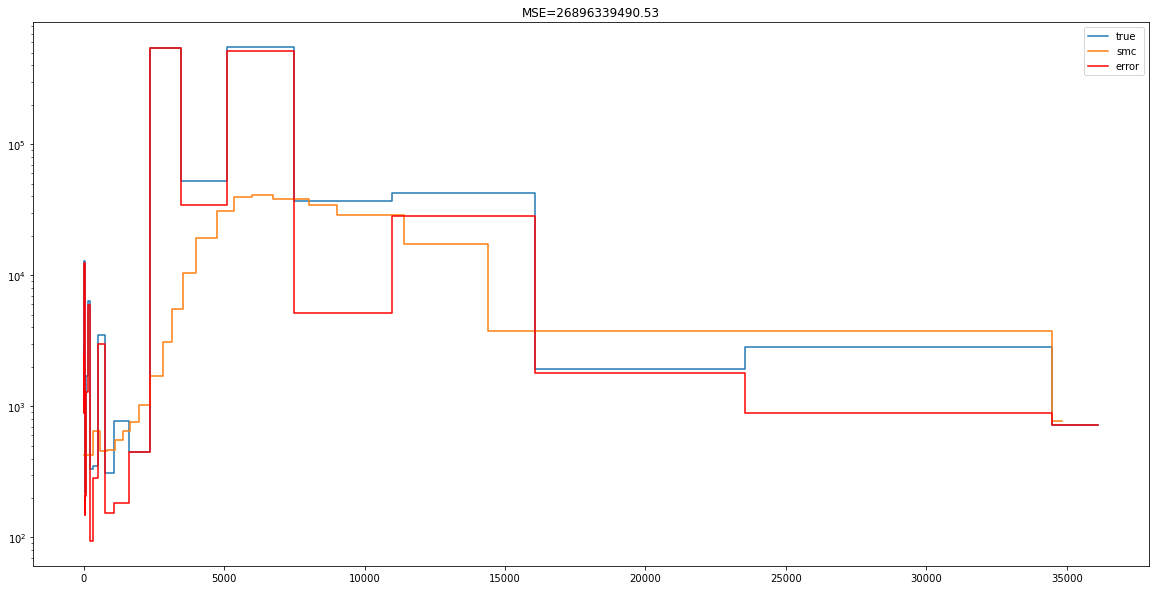

In [133]:
trueX, trueY, smcX, smcY = loadCSV_subsample()
plotError(trueX, trueY, smcX, smcY)